In [1]:
#関係を書いておけば点数アップ
#必要なライブラリのインポート
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
#図にロボットの位置の分布を描画するための楕円生成
def sigma_ellipse(p, cov, n): 
    eig_vals, eig_vec = np.linalg.eig(cov)#固有値計算
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180#ロボットの角度(ワールド座標基準)を計算（この場合楕円の角度)
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [3]:

class KalmanFilter: ###kf4init
    def __init__(self, envmap, init_pose, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        """
        ロボットの初期信念
        はじめロボットは初期位置が定まっているため、誤差(分散)が少ない
        """
        self.belief = multivariate_normal(mean=init_pose,cov=np.diag([1e-10, 1e-10, 1e-10])) 
        """
        移動時に生じるロボットの誤差は、標準分散であると仮定している。
        直進運動時に生じる誤差と旋回運動により生じる誤差の2つの誤差が生じると仮定する
        """
        self.motion_noise_stds = motion_noise_stds#ロボットの移動時の標準偏差(ノイズ)
        self.map = envmap  #ロボットが移動す地図
        self.distance_dev_rate = distance_dev_rate#ロボットの移動距離の分散
        self.direction_dev = direction_dev#ロボットの移動方向の分散
    """
    ランドマークを観測
    """
    def observation_update(self, observation):  #追加
        #観測されたランドマークの数分繰り返す
        for d in observation:
            """
            ランドマークの基本情報(ランドマークの座標、ランドマーク番号)を取得する
            この情報を用い、ロボットの姿勢の信念を更新する。
            """
            #配列からランドマークの場所とランドマーク番号を取得
            z = d[0]#ランドマークの座標取得
            obs_id = d[1]#ランドマーク番号取得
            
            """
            ###H観測行列の生成###
            ランドマークを観測する事により得られたロボットの姿勢を計算しする為に必要な観測行列を生成する。
            """
            mx, my = self.map.landmarks[obs_id].pos#map上のランドマークの姿勢を取得
            mux, muy, mut = self.belief.mean#ロボットの位置(ノイズ付き)を取得
            #ロボットとランドマーク間の距離を算出
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)
            
            #観測行列の生成
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])#テーラー展開しH行列を生成する
            
            ###Qの計算(ノイズの共分散行列)###
            """
            ランドマークを観測した時、観測結果に対しても当然誤差が加わる事も十分に考えられる。
            この個所では観測したランドマークの姿勢の誤差を表す共分散行列Qを計算する。
            """
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos)#相対距離を求める
            distance_dev = self.distance_dev_rate*hmu[0]#距離の偏差を計算
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2]))#共分散行列を求める
            
            """
            カルマンゲインの計算
            
            """
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            ###更新###
            """
            計算したカルマンゲインを元にロボットの姿勢の信念の分布を更新
            """
            self.belief.mean += K.dot(z - hmu)#カルマンゲインを元に信念を更新
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)#ロボットの姿勢の共分散行列を更新
    
    """
    ロボットの状態を更新。
    ロボットに制御入力を加えると状態方程式に基づきロボットがシミュレーター内を移動させる。
    実環境の場合ロボットは制御入力に対し必ず誤差が生じる。この時に生じる誤差もmotion_update内で反映させる。
    """
    #nu:制御入力 omega: time:時間
    def motion_update(self, nu, omega, time): #追加
        """
        行列M,Aを計算する時、計算式の中にomegaと、nuが分母になる式が存在する。(ロボットの停止状態)
        これらが0になると式が無限大になるのでomegaと、nuが0になる場合、十分に小さい値を代入する。
        """
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
        if abs(nu) < 1e-5:         nu = 1e-5#ゼロにすると式が変わるので避ける

        """
        移動時に生じるロボットの誤差は、標準分散であると仮定(直進運動と旋回運動に誤差が発生)
        """
        v = self.motion_noise_stds#ロボットが移動すつ時に生じる誤差(共分散行列)を取得
        #制御空間における雑音の共分散行列を生成
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
       
        
        """
        ロボットの運動モデルを用い、姿勢の確率分布(self.belie)を更新する
        運動モデルを線形化する必要があるので、テーラー展開を用い線形化する。
        """
        t = self.belief.mean[2]#角速度を取得
        st, ct = math.sin(t), math.cos(t)#ロボット座標系上の移動方向を計算
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time)#世界座標基準上のロボットの移動方向
        #状態方程式を制御入力uで偏微分し、線形化する
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        ###F:µt−1付近でxの変化に対してどれだけの割合で変化するかを求めた行列
        ###線形化した時に生じる誤差を補正
        F = np.diag([1.0, 1.0, 1.0])#入力の1次元行列が対角項になるような二次元配列を作成
        #テーラー展開で線形化
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
        
        #信念を更新
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)#共分散行列の更新
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)#信念の中心(平均)を計算(平均値)
        
    """
    ロボットの姿勢の確率分布を表示するためのメゾット
    推定3σ範囲を描画
    """
    def draw(self, ax, elems):
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)#楕円を生成
        elems.append(ax.add_patch(e))#生成した楕円を追加する

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean#ロボットの位置の信念
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3#3シグマ範囲を計算
        #表示する3つの楕円の大きさを生成
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        #表示する楕円の色、太さを指定
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
"""
実際にカルマンフィルタを用いロボットの姿勢を推定するクラス
"""
class KfAgent(Agent): 
    def __init__(self, time_interval, nu, omega, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        super().__init__(nu, omega)#Agentのインスタンスを生成
        self.kf = KalmanFilter(envmap, init_pose, motion_noise_stds)#カルマンフィルタを用意 
        self.time_interval = time_interval#制御周期を設定
        #制御入力記録用変数
        self.prev_nu = 0.0#制御入力(距離)
        self.prev_omega = 0.0#制御入力(方向)
    """
    カルマンフィルタを用い姿勢を計算
    """
    def decision(self, observation=None):  ###kfagent2
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) #ロボットの状態を更新
        self.prev_nu, self.prev_omega = self.nu, self.omega#制御入力記録用変数に制御入力を保存
        self.kf.observation_update(observation)   #観測したランドマークの情報を
        return self.nu, self.omega
    """
    カルマンフィルタで計算した姿勢と3シグマ範囲を描画
    """
    def draw(self, ax, elems): 
        self.kf.draw(ax, elems)#3シグマ範囲を描画

<IPython.core.display.Javascript object>


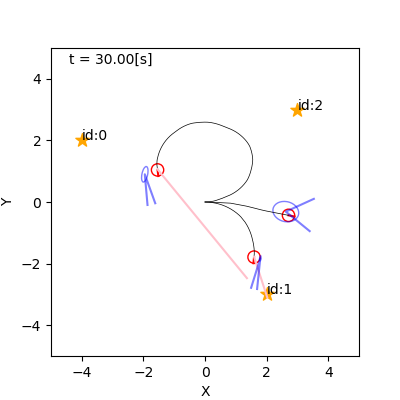

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1#制御周期
    world = World(30, time_interval)#0.1秒間隔で30秒間シミュレーションする

    """
    地図を生成し, 3つランドマークを地図上に追加する。
    """
    m = Map()#地図を生成 
    #ランドマークを地図上に配置
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    
    #地図を登録
    world.append(m)          

    """
    ロボットを作る
    「円運動をするロボット」「直線運動をするロボット」「右方向に曲がるロボット」を用意する。
    それぞれのロボットに対してカルマンフィルタを用い姿勢を推定し、推定結果を表示させる。
    """
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m)#地図上を回転するロボットを用意(制御入力を決める)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")#ロボットを作成
    world.append(r)#worldにロボットを追加
    
    linear = KfAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T, m)#地図上を真っ直ぐ移動するロボットを用意(制御入力を決める)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=linear, color="red")#ロボットを作成
    world.append(r)#worldにロボットを追加
    
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, np.array([0, 0, 0]).T, m)#ロボット座標系で右へ移動するロボットを用意(制御入力を決める)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=right, color="red")#ロボットを作成
    world.append(r)#worldにロボットを追加

    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき